In [1]:
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import os

import logging
logging.getLogger().setLevel(logging.INFO)

from alphabase.spectral_library.flat import SpecLibFlat
from alphabase.spectral_library.base import SpecLibBase
from alphabase.spectral_library.reader import LibraryReaderBase
from tqdm import tqdm
from alphabase.peptide.precursor import get_mod_seq_formula
from alphabase.constants.isotope import IsotopeDistribution
from alphadia.extraction.utils import reannotate_fragments
from alphabase.psm_reader import psm_reader_provider

INFO:root:


In [2]:
import warnings 

def fragment_number(precursor_df, fragment_intensity_df) :
    if not set(['frag_start_idx', 'frag_stop_idx']).issubset(precursor_df.columns):
        warnings.warn('frag_start_idx and frag_stop_idx not in dataframe')
        return
    
    n_fragments = []
    
    for start, stop in zip(precursor_df['frag_start_idx'].values, precursor_df['frag_stop_idx'].values):
        n_fragments += [np.sum(fragment_intensity_df.iloc[start:stop].values > 0)]

    precursor_df['n_fragments'] = n_fragments

def calc_isotope_dist(precursor_df, max_isotope = 6, min_intensity = 0.001):
    isotope_dist = IsotopeDistribution()

    col_names = ['i_{}'.format(i) for i in range(max_isotope)]
    precursor_df[col_names] = 0.

    for i in tqdm(range(len(precursor_df))):

        row = precursor_df.iloc[i]
        dist, mono = isotope_dist.calc_formula_distribution(
            get_mod_seq_formula(row['sequence'], row['mods'])
        )
        dist[dist < 0.001] = 0.
        dist = dist / dist.sum()
        precursor_df.loc[i, col_names] = dist[:max_isotope]

In [3]:
lib_location = '/Users/georgwallmann/Documents/data/alphadia_benchmarking/libraries/marvin_scp/MSfragger_library_mod_noLossType.tsv'
#insilico_lib_location = '/Users/georgwallmann/Documents/data/libraries/2022_111_brunner_2022_1ng_all_29_human_trypsin_diann_decoy.hdf'
output_location = '/Users/georgwallmann/Documents/data/alphadia_benchmarking/libraries/marvin_scp/MSfragger_library_mod_noLossType_d0_d4_d8_shared_eg.hdf'

In [4]:
# create dense library from diann psm file
target_lib = LibraryReaderBase()
target_lib.add_modification_mapping(
    {'Oxidation@M':['M(Oxidation)'],
     'Dimethyl@K':['K(Dimethyl)'],
     'Dimethyl@R':['R(Dimethyl)'],
     'Dimethyl@Any N-term':['(Dimethyl)']
    }
)
psm = target_lib.import_file(lib_location)

In [5]:
target_lib.fragment_mz_df

,b_z1,b_z2,y_z1,y_z2,b_modloss_z1,b_modloss_z2,y_modloss_z1,y_modloss_z2
0,130.086255,65.546766,940.499926,470.753601,0.0,0.0,0.0,0.0
1,267.145167,134.076222,803.441015,402.224146,0.0,0.0,0.0,0.0
2,430.208495,215.607886,640.377686,320.692481,0.0,0.0,0.0,0.0
3,545.235438,273.121357,525.350743,263.179010,0.0,0.0,0.0,0.0
4,642.288202,321.647739,428.297979,214.652628,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
554114,259.128848,0.000000,646.355888,0.000000,0.0,0.0,0.0,0.0
554115,445.208161,0.000000,460.276575,0.000000,0.0,0.0,0.0,0.0
554116,558.292225,0.000000,347.192511,0.000000,0.0,0.0,0.0,0.0
554117,673.319168,0.000000,232.165568,0.000000,0.0,0.0,0.0,0.0


In [6]:

target_lib.precursor_df['decoy'] = 0
target_lib._precursor_df['channel'] = 0
target_lib._fragment_mz_df = target_lib._fragment_mz_df[['b_z1', 'b_z2', 'y_z1', 'y_z2']]
target_lib._fragment_intensity_df = target_lib._fragment_intensity_df[['b_z1', 'b_z2', 'y_z1', 'y_z2']]
fragment_number(target_lib.precursor_df, target_lib._fragment_intensity_df)
target_lib._precursor_df['elution_group_idx'] = np.arange(len(target_lib._precursor_df))

In [7]:
calc_isotope_dist(target_lib.precursor_df)

100%|██████████| 45867/45867 [00:17<00:00, 2690.22it/s]


In [9]:
from alphabase.peptide import fragment

channel_lib_list = []
for channel, original_mod, new_mod in [
    (4, 'Dimethyl@', 'Dimethyl:2H(4)@'),
    (8, 'Dimethyl@', 'Dimethyl:2H(6)13C(2)@')
    ]:

    channel_lib = target_lib.copy()

    channel_lib._precursor_df['mods'] = channel_lib._precursor_df['mods'].str.replace(original_mod, new_mod)
    channel_lib._precursor_df['channel'] = channel
    fragment.update_precursor_mz(channel_lib._precursor_df)
    channel_lib.calc_fragment_mz_df()
    channel_lib_list += [channel_lib]
    channel_lib.precursor_df.head()


In [10]:
for lib in channel_lib_list:
    target_lib.append(lib)

In [11]:
target_lib.precursor_df.sort_values('elution_group_idx', inplace=True)
target_lib.remove_unused_fragments()

In [12]:
decoy_lib = SpecLibBase()
decoy_lib._precursor_df = target_lib.precursor_df.copy()
decoy_lib._fragment_mz_df = target_lib._fragment_mz_df.copy()
decoy_lib._fragment_intensity_df = target_lib._fragment_intensity_df.copy()


#decoy_lib.import_file(brunner_lib)
decoy_lib.decoy = 'diann'
decoy_lib.append_decoy_sequence()
decoy_lib.precursor_df = decoy_lib.precursor_df[decoy_lib.precursor_df['decoy'] == 1]
fragment.update_precursor_mz(decoy_lib._precursor_df)
#decoy_lib.calc_precursor_mz()


,mobility,sequence,genes,mod_sites,proteins,charge,rt,mods,precursor_mz,nAA,...,decoy,channel,n_fragments,elution_group_idx,i_0,i_1,i_2,i_3,i_4,i_5
0,0.799750,LSGMALR,GAPDH,0;4,P04406,2,20.749933,Dimethyl@Any N-term;Oxidation@M,396.225831,7,...,1,0,11,4274,0.598311,0.272195,0.098397,0.025780,0.005316,0.000000
1,0.884644,YLDLLLR,NUP155,0,O75694,2,77.984429,Dimethyl@Any N-term,467.292028,7,...,1,0,9,13419,0.521628,0.307775,0.123306,0.036861,0.008724,0.001706
2,0.884681,QNEEMLR,NONO,0,Q15233,2,10.708504,Dimethyl@Any N-term,474.234384,7,...,1,0,11,13423,0.552248,0.266703,0.127264,0.040340,0.010972,0.002473
3,0.884895,ELIEMLR,TRMT10C,0;5,Q7L0Y3,2,50.457494,Dimethyl@Any N-term;Oxidation@M,474.265153,7,...,1,0,10,13452,0.519239,0.306641,0.125038,0.038017,0.009210,0.001855
4,0.885155,QNEEVLR,RSRC2,0,Q7L4I2-2,2,18.496521,Dimethyl@Any N-term,458.248349,7,...,1,0,5,13487,0.586302,0.299256,0.090547,0.020233,0.003662,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137590,1.095016,ALSAAGAAGSAGGSSGAAGAAGGGAGAGTRPGDGGTASAGAAGPGAASK,CDV3,0;49,Q9UKY7,5,13.564690,Dimethyl:2H(6)13C(2)@Any N-term;Dimethyl:2H(6)...,754.786271,49,...,1,8,47,38174,0.141394,0.260841,0.256465,0.177225,0.096112,0.043393
137591,1.120423,ALSAAGAAGSAGGSSGAAGAAGGGAGAGTRPGDGGTASAGAAGPGAASK,CDV3,0;49,Q9UKY7,4,13.505330,Dimethyl:2H(6)13C(2)@Any N-term;Dimethyl:2H(6)...,943.231020,49,...,1,8,75,39963,0.141394,0.260841,0.256465,0.177225,0.096112,0.043393
137592,1.095016,ALSAAGAAGSAGGSSGAAGAAGGGAGAGTRPGDGGTASAGAAGPGAASK,CDV3,0;49,Q9UKY7,5,13.564690,Dimethyl@Any N-term;Dimethyl@K,751.568523,49,...,1,0,47,38174,0.141394,0.260841,0.256465,0.177225,0.096112,0.043393
137593,1.095016,ALSAAGAAGSAGGSSGAAGAAGGGAGAGTRPGDGGTASAGAAGPGAASK,CDV3,0;49,Q9UKY7,5,13.564690,Dimethyl:2H(4)@Any N-term;Dimethyl:2H(4)@K,753.178566,49,...,1,4,47,38174,0.141394,0.260841,0.256465,0.177225,0.096112,0.043393


In [13]:
from peptdeep.pretrained_models import ModelManager
from alphabase.peptide.fragment import get_charged_frag_types

model_mgr = ModelManager()

model_mgr.nce = 30
model_mgr.instrument = 'timsTOF'

In [14]:
decoy_lib.charged_frag_types = target_lib.charged_frag_types

In [15]:
res = model_mgr.predict_all(
    decoy_lib.precursor_df,
    predict_items=['ms2'],
    frag_types = decoy_lib.charged_frag_types,
)
#decoy_lib.calc_fragment_mz_df()

2023-03-08 23:44:54> Using multiprocessing with 8 processes ...
2023-03-08 23:44:54> Predicting ms2 ...


100%|██████████| 43/43 [00:28<00:00,  1.52it/s]


In [16]:
decoy_lib._precursor_df = res['precursor_df']
decoy_lib._fragment_mz_df = res['fragment_mz_df']
decoy_lib._fragment_intensity_df = res['fragment_intensity_df']

In [17]:
target_lib.append(decoy_lib)

/Users/georgwallmann/Documents/git/alphabase/alphabase/spectral_library/base.py:190: UserWarning: Unmatched columns in second dataframe will be dropped: {'nce', 'instrument'}.
  warnings.warn(


In [18]:
target_lib.precursor_df['n_fragments_allowed'] = target_lib.precursor_df['n_fragments']

In [19]:
fragment_number(target_lib.precursor_df, target_lib._fragment_intensity_df)

<AxesSubplot:xlabel='n_fragments', ylabel='Count'>

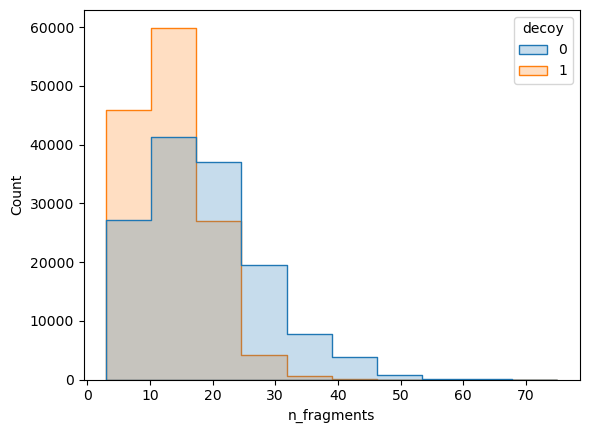

In [20]:
import seaborn as sns
sns.histplot(target_lib.precursor_df, x='n_fragments', hue='decoy', element='step', bins=10)

In [22]:
len(target_lib.precursor_df)

275196

In [23]:
target_lib.save_hdf(output_location)

In [21]:
target_lib.fragment_cardinality_df = fragment.calc_fragment_cardinality(target_lib.precursor_df, target_lib._fragment_mz_df)